In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

# Step 1: Retrieve Historical Data
ticker = "AAPL"  # example ticker
data = yf.download(ticker, start="2020-01-01", end="2023-01-01")
data = data['Close'].reset_index()
data.columns = ['date', 'value']

# Step 2: Preprocess the Data
scaler = MinMaxScaler()
data['value'] = scaler.fit_transform(data[['value']])

data['time_idx'] = pd.RangeIndex(len(data))
data['group'] = 0

# Convert to numpy array
values = data['value'].values

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 90
X, y = create_sequences(values, seq_length)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

#### TSMIXER

class TSMixer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = seq_length
hidden_size = 50
output_size = 1

model = TSMixer(input_size, hidden_size, output_size)

[*********************100%%**********************]  1 of 1 completed


In [8]:
values

array([0.15085277, 0.14505529, 0.14976075, 0.14696135, 0.15649137,
       0.16927753, 0.17066729, 0.18383068, 0.17533306, 0.17267259,
       0.18041574, 0.18734493, 0.1830564 , 0.18529994, 0.18833764,
       0.18651102, 0.16792745, 0.18528007, 0.19848314, 0.19754999,
       0.16903929, 0.16735166, 0.18758317, 0.19274529, 0.20021045,
       0.18992596, 0.19294378, 0.18909205, 0.2041615 , 0.19953542,
       0.19969428, 0.18788097, 0.19705363, 0.190462  , 0.17606765,
       0.14654436, 0.12649154, 0.13556496, 0.09758373, 0.09726605,
       0.14779519, 0.12895351, 0.15559791, 0.13610106, 0.12837772,
       0.08299089, 0.12105149, 0.1013759 , 0.04737229, 0.1064189 ,
       0.03542004, 0.05656483, 0.04427503, 0.04052257, 0.00966905,
       0.        , 0.04469198, 0.0419918 , 0.06764351, 0.04639945,
       0.0604364 , 0.05940397, 0.03283898, 0.04082037, 0.03383169,
       0.07564478, 0.06960907, 0.08279233, 0.08660432, 0.09704768,
       0.12444655, 0.11924474, 0.12373183, 0.11600849, 0.10435

In [5]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    
    # calculate loss
    loss = criterion(outputs, y_train)
    
    # backpropagate
    loss.backward()
    
    # update weights
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([532])) that is different to the input size (torch.Size([532, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0896
Epoch [20/100], Loss: 0.0807
Epoch [30/100], Loss: 0.0754
Epoch [40/100], Loss: 0.0706
Epoch [50/100], Loss: 0.0664
Epoch [60/100], Loss: 0.0626
Epoch [70/100], Loss: 0.0593
Epoch [80/100], Loss: 0.0566
Epoch [90/100], Loss: 0.0544
Epoch [100/100], Loss: 0.0526


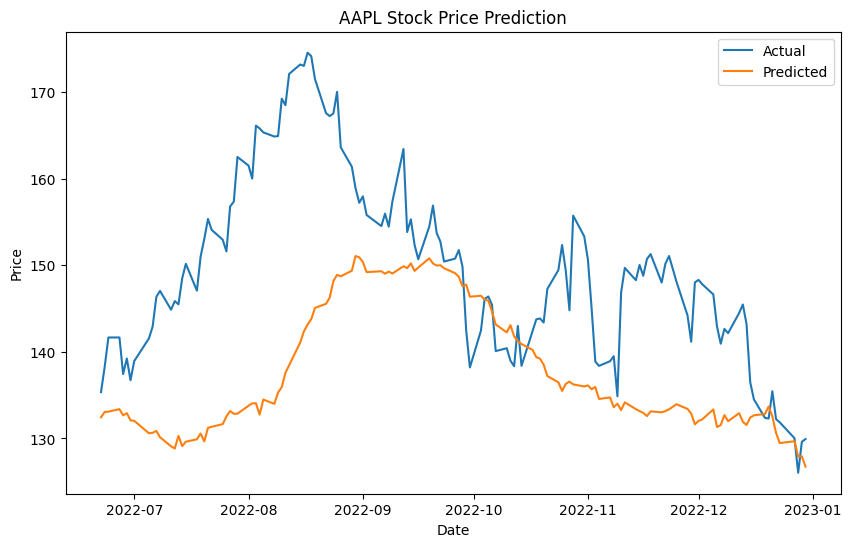

In [3]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(data['date'][len(data) - len(y_test):], y_test, label='Actual')
plt.plot(data['date'][len(data) - len(predictions):], predictions, label='Predicted')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Forecast

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\igor-\AppData\Local\Temp\ipykernel_6728\3832827278.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='ffill', inplace=True)
C:\Users\igor-\AppData\Local\Temp\ipykernel_6728\3832827278.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='bfill', inplace=True)
10:27:50 - cmdstanpy - INFO - Chain [1] start processing
10:27:50 - cmdstanpy - INFO - Chain [1] done processing
10:27:50 - cmdstanpy - INFO - Chain [1] start processing
10:27:51 - cmdstanpy - INFO - Chain [1] done processing
10:27:51 - cmdstanpy - INFO - Chain [1] start processing


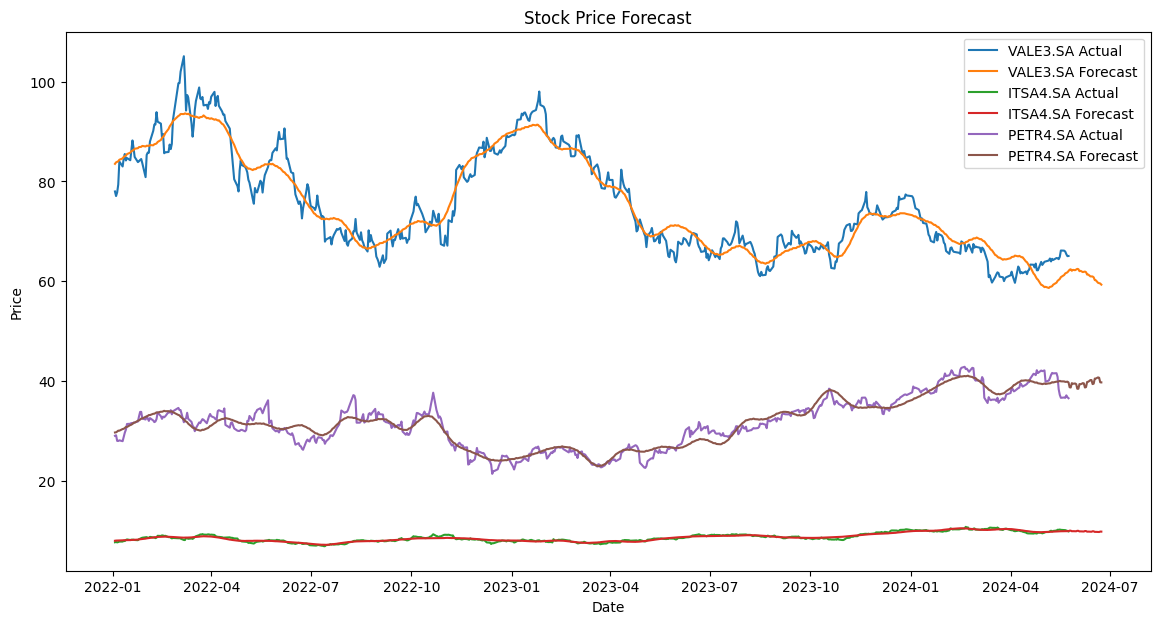

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Step 2: Download historical data
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start="2022-01-01", end="2024-05-25")


close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})

close_prices.fillna(method='ffill', inplace=True)
close_prices.fillna(method='bfill', inplace=True)

models = {}
forecasts = {}
forecast_period = 30  # days to forecast

for ticker in tickers:
    df = close_prices[[ticker]].reset_index()
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    models[ticker] = model
    forecasts[ticker] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Step 5: Make predictions
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(close_prices[ticker], label=f"{ticker} Actual")
    plt.plot(forecasts[ticker]['ds'], forecasts[ticker]['yhat'], label=f"{ticker} Forecast")

plt.legend()
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [30]:
import datetime
from datetime import timedelta
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
to_date

'2024-07-01'

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
C:\Users\igor-\AppData\Local\Temp\ipykernel_6728\1245937027.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='ffill', inplace=True)
C:\Users\igor-\AppData\Local\Temp\ipykernel_6728\1245937027.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='bfill', inplace=True)
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] done processing
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] done processing
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] done processing


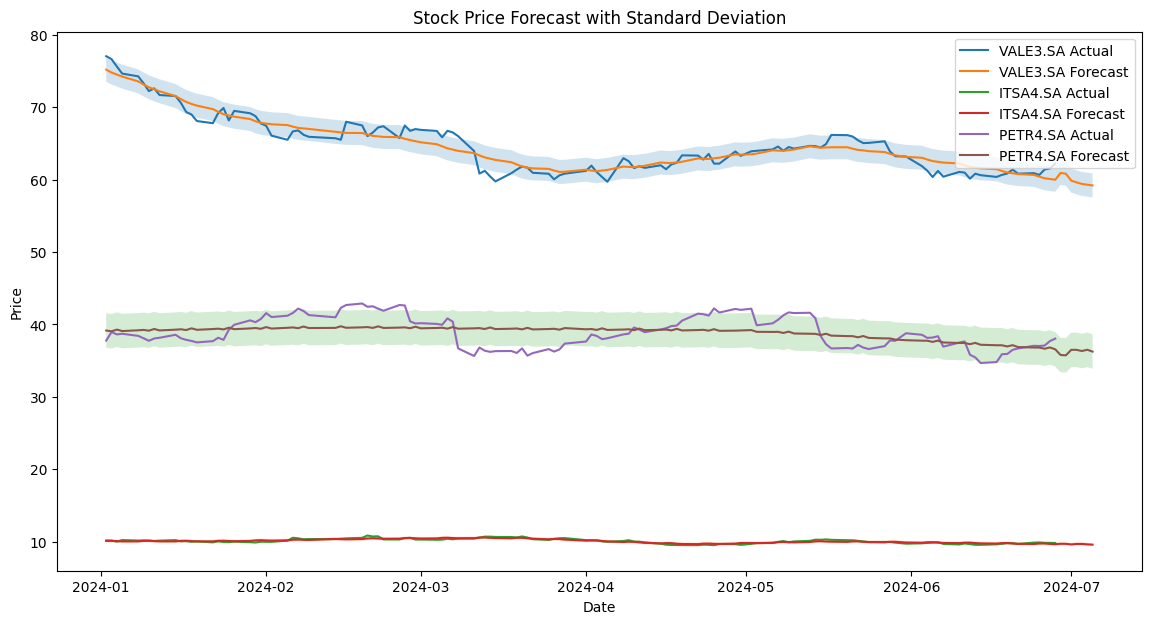

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Igor do futuro isso pega a data de ontem bjs
import datetime
from datetime import timedelta
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start="2024-01-01", end=to_date)

#Vamor treinar esse baguio toda vez que rodar

close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})

close_prices.fillna(method='ffill', inplace=True)
close_prices.fillna(method='bfill', inplace=True)

models = {}
forecasts = {}
forecast_period = 7  # Tempo de previsão Escolhe um valor normal IGOOR

for ticker in tickers:
    df = close_prices[[ticker]].reset_index()
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    models[ticker] = model
    forecasts[ticker] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    forecast['std'] = (close_prices[ticker].rolling(window=22).std().iloc[-1])*2 #Escolhe 3 desvios 1 ou qualquer coisa
    forecast['yhat_upper_std'] = forecast['yhat'] + forecast['std']
    forecast['yhat_lower_std'] = forecast['yhat'] - forecast['std']
    forecasts[ticker] = forecast

plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(close_prices[ticker], label=f"{ticker} Actual")
    plt.plot(forecasts[ticker]['ds'], forecasts[ticker]['yhat'], label=f"{ticker} Forecast")
    plt.fill_between(forecasts[ticker]['ds'], forecasts[ticker]['yhat_lower_std'], forecasts[ticker]['yhat_upper_std'], alpha=0.2)

plt.legend()
plt.title('Stock Price Forecast with Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import datetime

# Define the date range
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

# Define the tickers
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]

# Download the data
data = {ticker: yf.download(ticker, start="2023-07-01", end=to_date) for ticker in tickers}

# Prepare the close prices DataFrame
close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})
close_prices.fillna(method='ffill', inplace=True)
close_prices.fillna(method='bfill', inplace=True)

# Forecasting parameters
forecast_period = 7

# Initialize dictionaries to store models and forecasts
models = {}
forecasts = {}

# Train the models and make forecasts
for ticker in tickers:
    df = close_prices[[ticker]].reset_index()
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    
    std_dev = close_prices[ticker].rolling(window=22).std().iloc[-1] * 2
    forecast['std'] = std_dev
    forecast['yhat_upper_std'] = forecast['yhat'] + forecast['std']
    forecast['yhat_lower_std'] = forecast['yhat'] - forecast['std']
    
    models[ticker] = model
    forecasts[ticker] = forecast

# Prepare the data for Excel
excel_data = {}
for ticker in tickers:
    forecast_df = forecasts[ticker][['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_lower_std', 'yhat_upper_std', 'std']]
    forecast_df['type'] = 'prediction'
    actual_df = close_prices[[ticker]].reset_index()
    actual_df.columns = ['ds', 'y']
    actual_df['type'] = 'actual'
    combined_df = pd.concat([actual_df, forecast_df], ignore_index=True)
    combined_df['date'] = combined_df['ds']
    excel_data[ticker] = combined_df

# Save to Excel
file_path = 'stock_forecasts_with_types_and_date.xlsx'
with pd.ExcelWriter(file_path) as writer:
    for ticker in tickers:
        excel_data[ticker].to_excel(writer, sheet_name=ticker, index=False)

file_path

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\igor-\AppData\Local\Temp\ipykernel_32812\2586682799.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='ffill', inplace=True)
C:\Users\igor-\AppData\Local\Temp\ipykernel_32812\2586682799.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='bfill', inplace=True)
15:09:41 - cmdstanpy - INFO - Chain [1] start processing
15:09:41 - cmdstanpy - INFO - Chain [1] done processing
15:09:41 - cmdstanpy - INFO - Chain [1] start processing
15:09:41 - cmdstanpy - INFO - Chain [1] done processing
15:09:41 - cmdstanpy - INFO - Chain [1] start processin

'stock_forecasts_with_types_and_date.xlsx'

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import datetime

# Define the date range
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

# Define the tickers
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]

# Download the data
data = {ticker: yf.download(ticker, start="2024-01-01", end=to_date) for ticker in tickers}

# Prepare the close prices DataFrame
close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})

# Forecasting parameters
forecast_period = 7

# Initialize dictionaries to store models and forecasts
models = {}
forecasts = {}

# Train the models and make forecasts
for ticker in tickers:
    df = close_prices[[ticker]].reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'])  # Ensure 'ds' is in date format
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    
    std_dev = close_prices[ticker].rolling(window=22).std().iloc[-1] * 2
    forecast['std'] = std_dev
    forecast['yhat_upper_std'] = forecast['yhat'] + forecast['std']
    forecast['yhat_lower_std'] = forecast['yhat'] - forecast['std']
    
    models[ticker] = model
    forecasts[ticker] = forecast

# Prepare the data for Excel
excel_data = {}
for ticker in tickers:
    forecast_df = forecasts[ticker][['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_lower_std', 'yhat_upper_std', 'std']]
    forecast_df['type'] = 'prediction'
    forecast_df['y'] = np.nan
    forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])  # Ensure 'ds' is in date format
    
    actual_df = close_prices[[ticker]].reset_index()
    actual_df.columns = ['ds', 'y']
    actual_df['type'] = 'actual'
    actual_df['yhat'] = np.nan
    actual_df['yhat_lower'] = np.nan
    actual_df['yhat_upper'] = np.nan
    actual_df['yhat_lower_std'] = np.nan
    actual_df['yhat_upper_std'] = np.nan
    actual_df['std'] = np.nan
    actual_df['ds'] = pd.to_datetime(actual_df['ds'])  # Ensure 'ds' is in date format
    
    combined_df = pd.concat([actual_df, forecast_df], ignore_index=True)
    
    excel_data[ticker] = combined_df

# Save to Excel
with pd.ExcelWriter('stock_forecasts_with_types_and_date.xlsx') as writer:
    for ticker in tickers:
        excel_data[ticker].to_excel(writer, sheet_name=ticker, index=False)

print("Forecasts have been saved to stock_forecasts_with_types_and_date.xlsx")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:08 - cmdstanpy - INFO - Chain [1] done processing
14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:08 - cmdstanpy - INFO - Chain [1] done processing
14:15:09 - cmdstanpy - INFO - Chain [1] start processing
14:15:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\igor-\AppData\Local\Temp\ipykernel_20240\3810404620.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['type'] = 'prediction'
C:\Users\igor-\AppData\Local\Temp\ipykernel_20240\3810404620.

Forecasts have been saved to stock_forecasts_with_types_and_date.xlsx


##### Drive API funfando

In [60]:
from Google import Create_Service
from googleapiclient.http import MediaFileUpload
CLIENT_SECRET_FILE = 'client_secrets.json'
API_NAME = 'drive'
API_VERSION ='v3'
SCOPES = ['https://www.googleapis.com/auth/drive']
service = Create_Service(CLIENT_SECRET_FILE,API_NAME,API_VERSION,SCOPES)

folder_id = '10uOsB9j6h6rh7BLJ'
file_names= ['stock_forecasts_with_types_and_date.xlsx']
mime_types = ['application/vnd.openxmlformats-officedocument.spreadsheetml.sheet']

for file_name, mime_type in zip(file_names,mime_types):
    file_metadata = {
        'name': file_name,
        'parents':[folder_id]
    }

    media=MediaFileUpload('./Saídas_modelos/{0}'.format(file_name),mimetype=mime_type)
    service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()

client_secrets.json-drive-v3-(['https://www.googleapis.com/auth/drive'],)
['https://www.googleapis.com/auth/drive']


RefreshError: ('invalid_grant: Bad Request', {'error': 'invalid_grant', 'error_description': 'Bad Request'})

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
# Define the date range
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]
data = {ticker: yf.download(ticker, start="2024-01-01", end=to_date) for ticker in tickers}

# Extract the closing prices
close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})

# Calculate the difference in closing prices by date
close_prices_diff = close_prices.diff().dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Criando as simulações

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Standard Deviation for each ticker (closing price differences):
VALE3.SA    0.861516
ITSA4.SA    0.116044
PETR4.SA    0.735493
dtype: float64
Random walk simulations saved to CSV files.


<Figure size 1500x700 with 0 Axes>

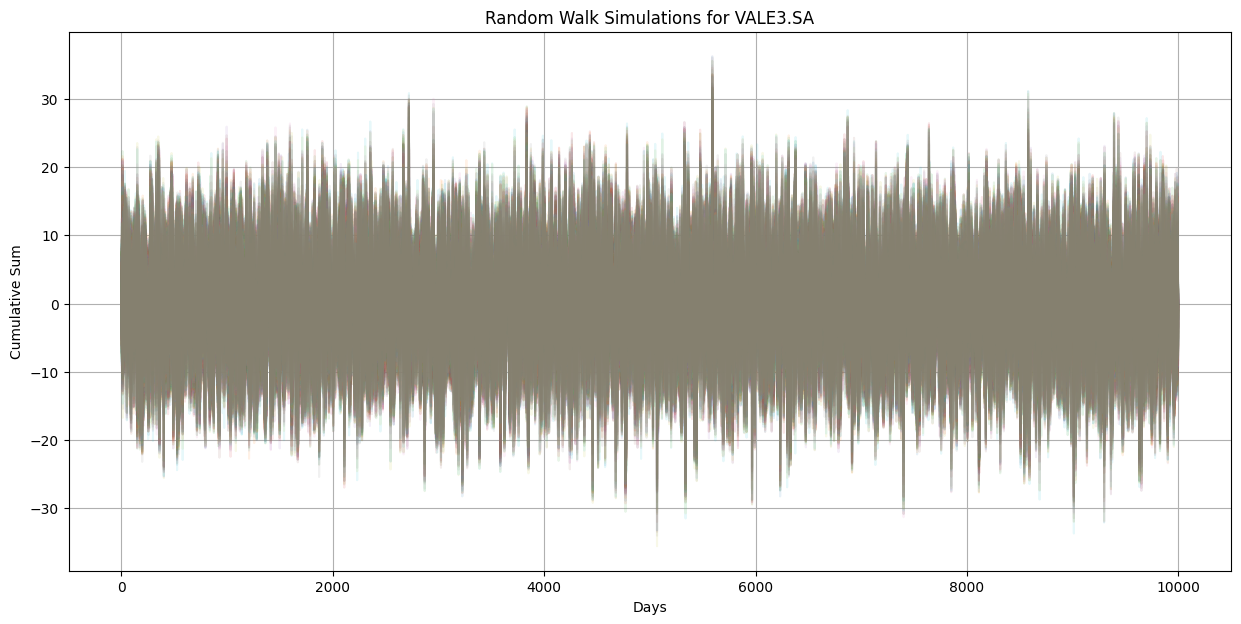

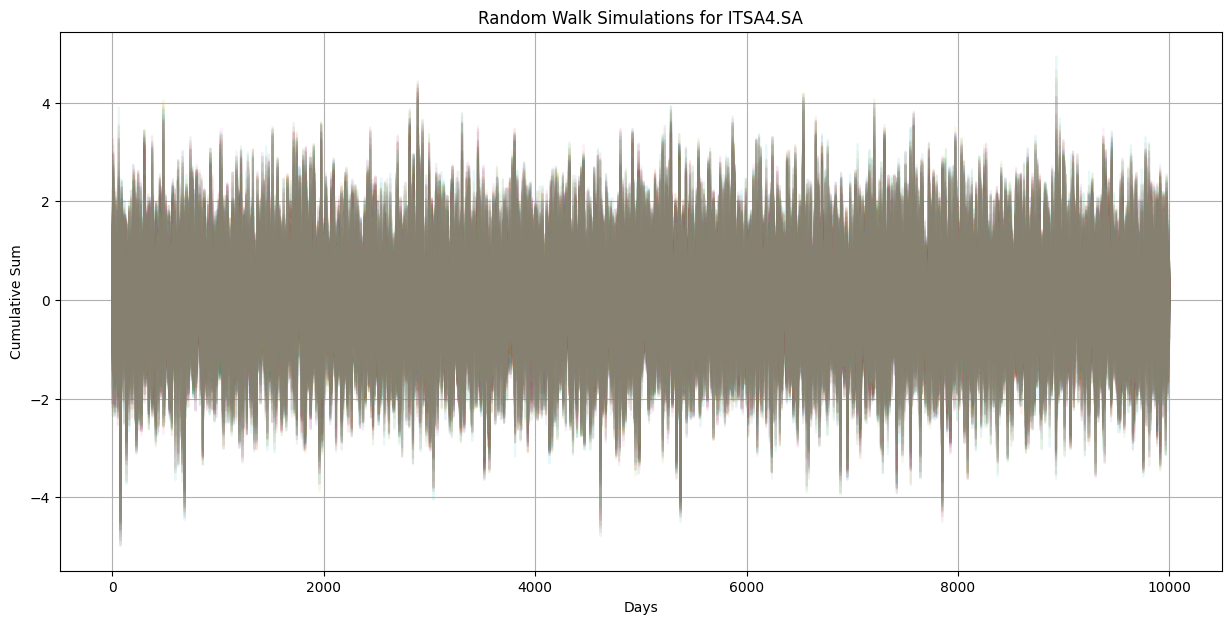

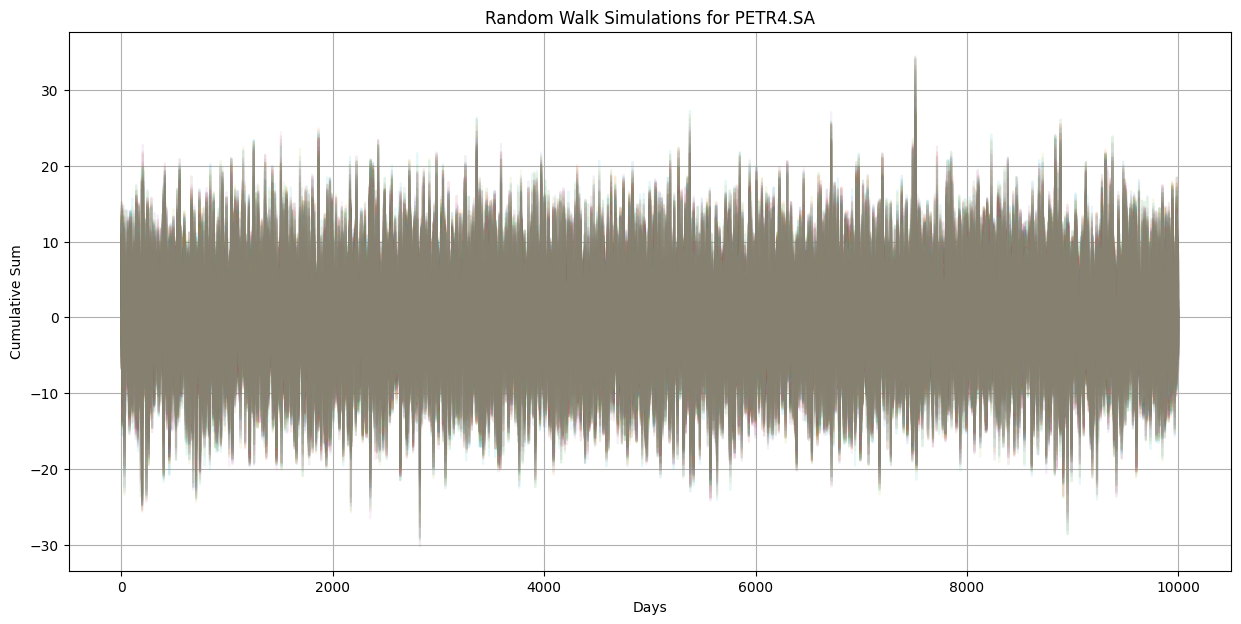

Random walk simulations saved to CSV files and plotted.


In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

# Define the date range
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]
data = {ticker: yf.download(ticker, start="2024-01-01", end=to_date) for ticker in tickers}

# Extract the closing prices
close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})

# Calculate the difference in closing prices by date
close_prices_diff = close_prices.diff().dropna()

# Calculate the standard deviation for each ticker based on closing price differences
std_dev_diff = close_prices_diff.std()
print("Standard Deviation for each ticker (closing price differences):")
print(std_dev_diff)

# Number of simulations
num_simulations = 10000
num_steps = 252  # Typically one trading year

# Create a random walk for each ticker
simulation_results = {}

for ticker in tickers:
    simulations = np.zeros((num_simulations, num_steps + 1))
    for i in range(num_simulations):
        steps = np.random.normal(0, std_dev_diff[ticker], num_steps)
        simulations[i, 1:] = np.cumsum(steps)
    simulation_results[ticker] = pd.DataFrame(simulations)

# Save the results to CSV files
for ticker, df in simulation_results.items():
    df.to_csv(f'Saídas_modelos/{ticker}_random_walk_simulations.csv', index=False)

print("Random walk simulations saved to CSV files.")


# Plot the results for each ticker
plt.figure(figsize=(15, 7))

for ticker in tickers:
    plt.figure(figsize=(15, 7))
    plt.plot(simulation_results[ticker].iloc[:, :100], alpha=0.1)  # Plot first 100 simulations for clarity
    plt.title(f'Random Walk Simulations for {ticker}')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Sum')
    plt.grid(True)
    plt.show()

print("Random walk simulations saved to CSV files and plotted.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\igor-\AppData\Local\Temp\ipykernel_20240\2683095502.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price = close_prices[ticker][-1]


Standard Deviation for each ticker (closing price differences):
VALE3.SA    0.858174
ITSA4.SA    0.115721
PETR4.SA    0.732638
dtype: float64
Mean return for each ticker (closing price differences):
VALE3.SA   -0.107923
ITSA4.SA   -0.001538
PETR4.SA    0.005000
dtype: float64
Standard Deviation for each ticker (closing prices):
VALE3.SA    3.811373
ITSA4.SA    0.319864
PETR4.SA    2.086059
dtype: float64
Price limits for each ticker (4 standard deviations):
VALE3.SA    79.939461
ITSA4.SA    11.356936
PETR4.SA    47.202251
dtype: float64


Simulating PETR4.SA: 100%|██████████| 100/100 [00:00<00:00, 611.47simulation/s]


<Figure size 1500x700 with 0 Axes>

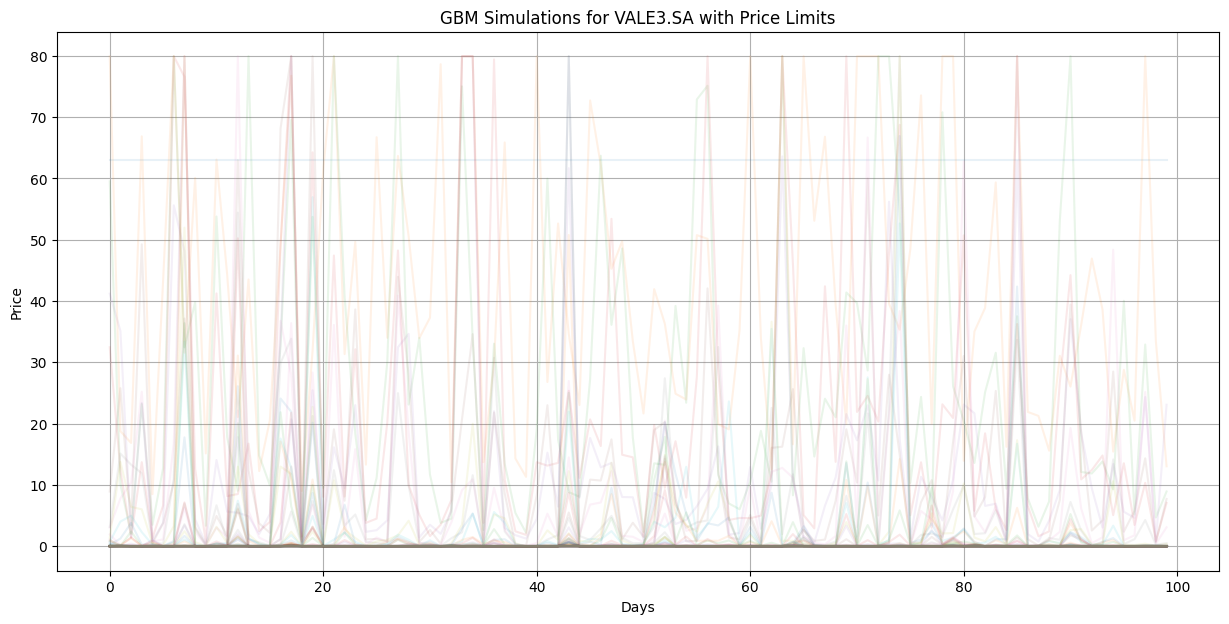

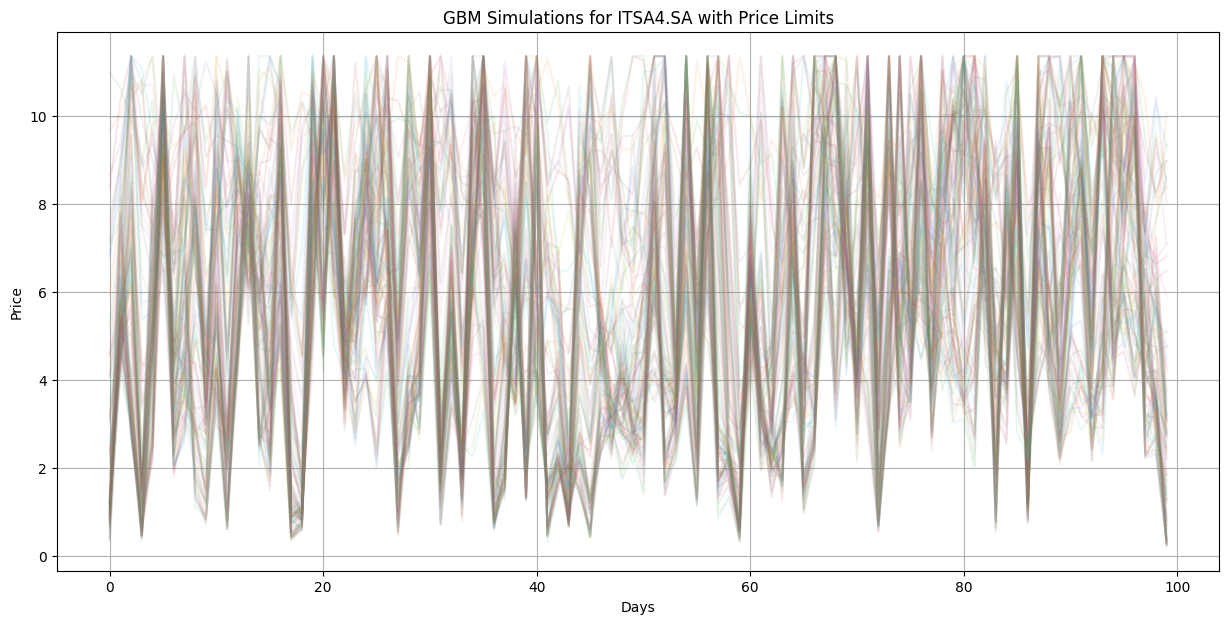

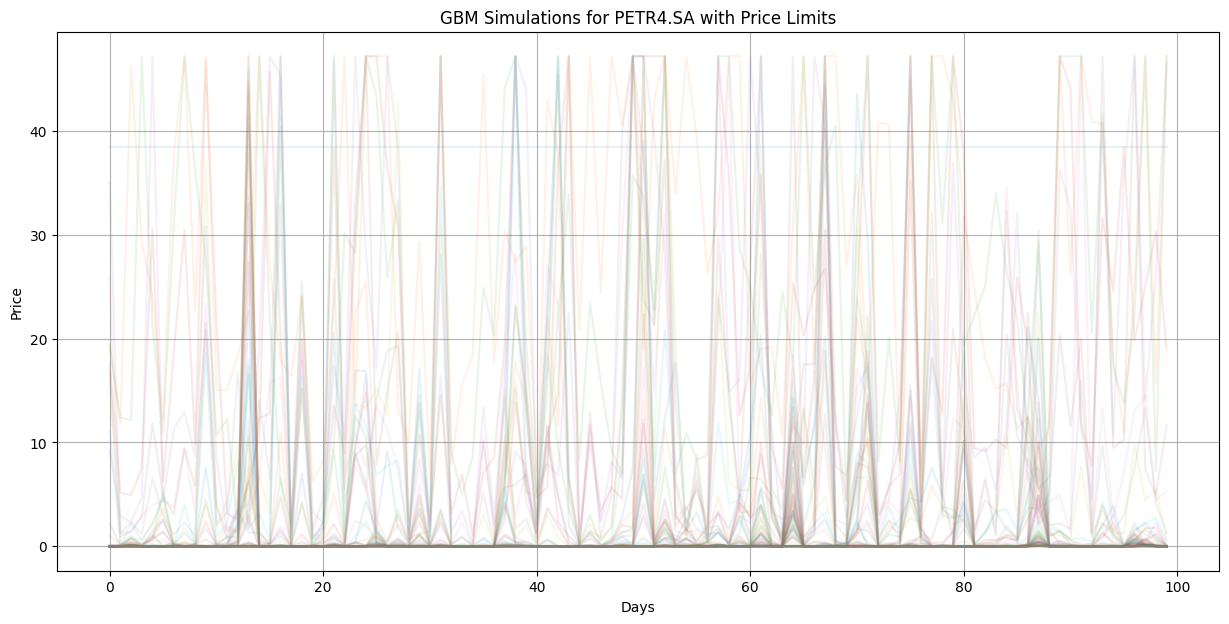

GBM simulations with price limits saved to CSV files and plotted.


In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm  # for progress bar

# Define the date range
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]
data = {ticker: yf.download(ticker, start="2024-01-01", end=to_date) for ticker in tickers}

# Extract the closing prices
close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})

# Calculate the difference in closing prices by date
close_prices_diff = close_prices.diff().dropna()

# Calculate the standard deviation and mean return for each ticker based on closing price differences
std_dev_diff = close_prices_diff.std()
mean_return = close_prices_diff.mean()
print("Standard Deviation for each ticker (closing price differences):")
print(std_dev_diff)
print("Mean return for each ticker (closing price differences):")
print(mean_return)

# Calculate the standard deviation of the closing prices
std_dev_prices = close_prices.std()
print("Standard Deviation for each ticker (closing prices):")
print(std_dev_prices)

# Define price limits (4 standard deviations)
price_limits = close_prices.mean() + 4 * std_dev_prices
print("Price limits for each ticker (4 standard deviations):")
print(price_limits)

# Number of simulations
num_simulations = 100
num_steps = 252  # Typically one trading year

# Create a random walk for each ticker using Geometric Brownian Motion with price limits
simulation_results = {}

for ticker in tickers:
    price = close_prices[ticker][-1]
    limit = price_limits[ticker]
    simulations = np.zeros((num_simulations, num_steps + 1))
    simulations[:, 0] = price
    for i in tqdm(range(num_simulations), desc=f'Simulating {ticker}', unit='simulation'):
        for t in range(1, num_steps + 1):
            drift = mean_return[ticker] - 0.5 * std_dev_diff[ticker]**2
            shock = std_dev_diff[ticker] * np.random.normal()
            new_price = simulations[i, t-1] * np.exp(drift + shock)
            # Apply the limit
            simulations[i, t] = min(new_price, limit)
    simulation_results[ticker] = pd.DataFrame(simulations)

    # Save the results to CSV files
    simulation_results[ticker].to_csv(f'Saídas_modelos/{ticker}_gbm_simulations_limited.csv', index=False)

plt.figure(figsize=(15, 7))
for ticker in tickers:
    plt.figure(figsize=(15, 7))
    plt.plot(simulation_results[ticker].iloc[:, :100], alpha=0.1)  
    plt.title(f'GBM Simulations for {ticker} with Price Limits')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

print("GBM simulations with price limits saved to CSV files and plotted.")

##### Fazer as predições antes de colocar os modelos de smiulações em cima

Criar para cada ticker um x_train y_train....

#### Tentativa de gridSearch

Saved future predictions for VALE3.SA to 'future_predictions_VALE3.SA.csv'
Transformed data for VALE3.SA:
                Open      High       Low    Volume
Date                                              
2023-10-02  0.437079  0.408520  0.415095  0.184473
2023-10-03  0.352809  0.367012  0.383648  0.252031
2023-10-04  0.370787  0.357182  0.352773  0.237311
2023-10-05  0.341011  0.339159  0.360206  0.190752
2023-10-06  0.342135  0.393774  0.369354  0.374881
Training with parameters: neurons=16, activation=relu, optimizer=adam, epochs=50, batch_size=8
Epoch 1/50


c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - loss: 4339.3716
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4327.5425 
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 4314.8521
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 4299.9697
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 4281.3936
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4257.1592 
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 4227.2705
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 4190.9673
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 4147.3545
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 4095.7017
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 4035.4631
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3966.2983 
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3888.0769 
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3800.8950 
Epoch 15/50
23/23 ━━━━━━━━━━━━━


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


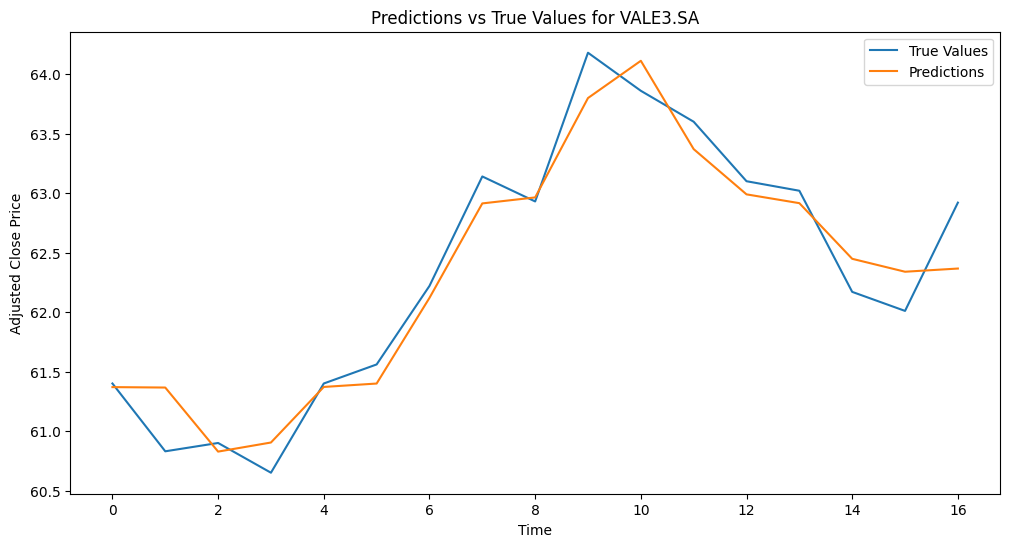

Transformed data for ITSA4.SA:
                Open      High       Low    Volume
Date                                              
2023-10-02  0.141125  0.128709  0.111410  0.285775
2023-10-03  0.086846  0.075080  0.076834  0.479111
2023-10-04  0.065134  0.100108  0.076834  0.377485
2023-10-05  0.086846  0.125134  0.099885  0.244934
2023-10-06  0.054279  0.132285  0.076834  0.483374
Training with parameters: neurons=16, activation=relu, optimizer=adam, epochs=50, batch_size=8
Epoch 1/50


c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 80.3109
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79.5010 
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 78.6617
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 77.6574
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 76.4114
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 74.8533
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72.9240 
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 70.5794
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.7964 
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 64.5770
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 60.9535
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 56.9856
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 52.7559 
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.3627 
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43

Best parameters for ITSA4.SA: {'neurons': 16, 'activation': 'relu', 'optimizer': 'sgd', 'epochs': 50, 'batch_size': 8}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


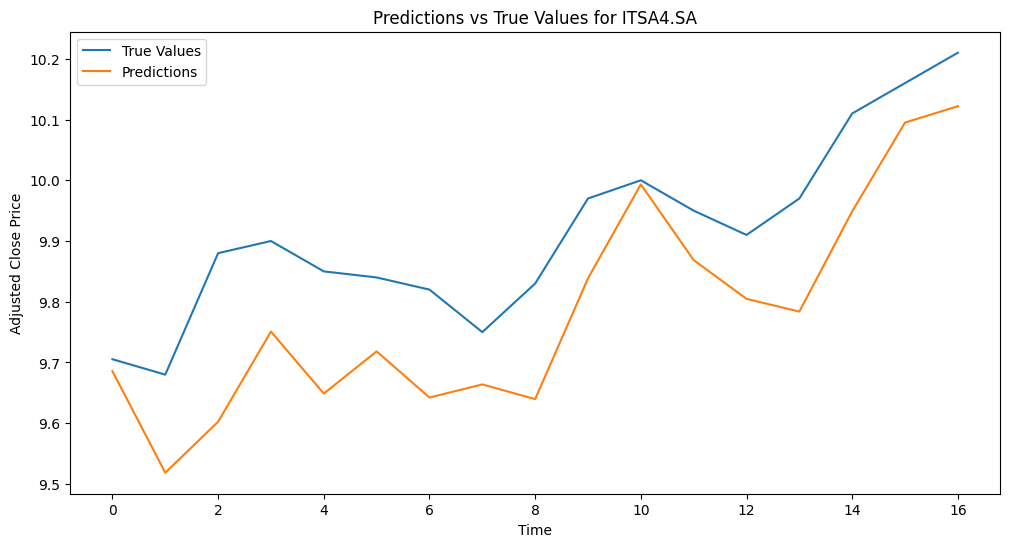

Transformed data for PETR4.SA:
                Open   High       Low    Volume
Date                                           
2023-10-02  0.198830  0.183  0.159688  0.099184
2023-10-03  0.142300  0.129  0.130477  0.115474
2023-10-04  0.106238  0.077  0.009737  0.349674
2023-10-05  0.000000  0.000  0.000000  0.103498
2023-10-06  0.008772  0.088  0.003895  0.162295
Training with parameters: neurons=16, activation=relu, optimizer=adam, epochs=50, batch_size=8
Epoch 1/50


c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - loss: 1077.7661
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1073.6659
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1069.1050
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1063.4949
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 1056.6438
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 1048.2527
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1037.9921
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1025.1421
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1008.6501
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 988.8381
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 965.5870
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 938.8676 
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 908.7711 
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 875.5030 
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━

Best parameters for PETR4.SA: {'neurons': 64, 'activation': 'relu', 'optimizer': 'sgd', 'epochs': 100, 'batch_size': 16}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


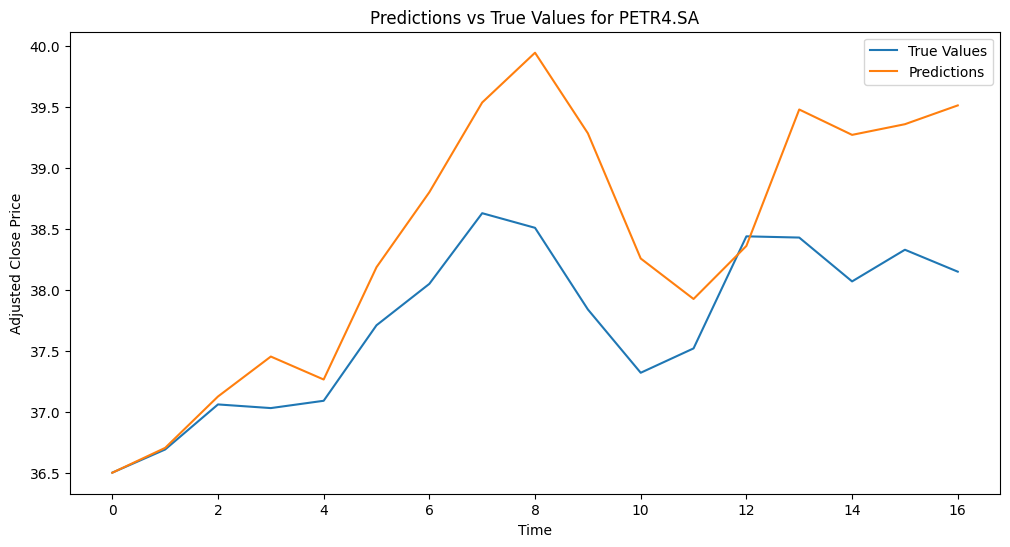

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Supondo que 'data' é um dicionário com DataFrames contendo os dados de cada ticker
# E 'tickers' é uma lista dos tickers

# Separando as features dos targets
output_var = pd.DataFrame({ticker: data[ticker]['Adj Close'] for ticker in tickers})
features = ['Open', 'High', 'Low', 'Volume']

# Inicializando o scaler
scaler = MinMaxScaler()

# Dicionários para guardar os resultados
results = {}

# Função para criar e treinar o modelo LSTM
def create_and_train_model(X_train, y_train, X_test, y_test, neurons, activation, optimizer, epochs, batch_size):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(1, X_train.shape[2]), activation=activation, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)
    loss = model.evaluate(X_test, y_test, verbose=0)
    return model, history, loss

# Função para configurar e treinar os modelos para cada ticker
def train_models(data, tickers, output_var, scaler, features):
    param_grid = {
        'neurons': [16, 32, 64],
        'activation': ['relu', 'tanh'],
        'optimizer': ['adam', 'sgd'],
        'epochs': [50, 100],
        'batch_size': [8, 16]
    }

    for ticker in tickers:
        df = data[ticker][features]  # Selecionando as features relevantes
        feature_transform = scaler.fit_transform(df)
        feature_transform = pd.DataFrame(data=feature_transform, columns=features, index=df.index)
        data[ticker][features] = feature_transform  # Substituindo os dados originais pelos escalados

        # Display the first few rows of the transformed DataFrame
        print(f"Transformed data for {ticker}:")
        print(feature_transform.head())

        # Usando TimeSeriesSplit para dividir os dados em conjuntos de treino e teste
        timesplit = TimeSeriesSplit(n_splits=10)
        ticker_results = {'X_train': [], 'X_test': [], 'y_train': [], 'y_test': []}
        
        for train_index, test_index in timesplit.split(feature_transform):
            X_train = feature_transform.iloc[train_index]
            X_test = feature_transform.iloc[test_index]
            y_train = output_var[ticker].iloc[train_index].values.ravel()
            y_test = output_var[ticker].iloc[test_index].values.ravel()
            
            # Convertendo para arrays numpy e redimensionando
            trainX = np.array(X_train)
            testX = np.array(X_test)
            X_train_reshaped = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
            X_test_reshaped = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
            
            # Guardando os resultados para cada divisão
            ticker_results['X_train'].append(X_train_reshaped)
            ticker_results['X_test'].append(X_test_reshaped)
            ticker_results['y_train'].append(y_train)
            ticker_results['y_test'].append(y_test)

        # Guardando os resultados no dicionário principal
        results[ticker] = ticker_results

        # Inicializando variáveis para armazenar os melhores hiperparâmetros
        best_loss = float("inf")
        best_params = None
        best_model = None

        # Executando a busca em grade manualmente
        for neurons in param_grid['neurons']:
            for activation in param_grid['activation']:
                for optimizer in param_grid['optimizer']:
                    for epochs in param_grid['epochs']:
                        for batch_size in param_grid['batch_size']:
                            print(f"Training with parameters: neurons={neurons}, activation={activation}, optimizer={optimizer}, epochs={epochs}, batch_size={batch_size}")
                            model, history, loss = create_and_train_model(
                                X_train_reshaped, y_train, X_test_reshaped, y_test,
                                neurons, activation, optimizer, epochs, batch_size
                            )
                            if loss < best_loss:
                                best_loss = loss
                                best_params = {
                                    'neurons': neurons,
                                    'activation': activation,
                                    'optimizer': optimizer,
                                    'epochs': epochs,
                                    'batch_size': batch_size
                                }
                                best_model = model
        
        # Exibindo os melhores hiperparâmetros
        print(f"Best parameters for {ticker}: {best_params}")

        # Salvando o melhor modelo
        best_model.save(f"best_model_{ticker}.h5")

        # Fazendo previsões com o melhor modelo
        predictions = best_model.predict(X_test_reshaped)
        results[ticker]['predictions'] = predictions
        results[ticker]['true_values'] = y_test

        # Plotando as previsões
        plt.figure(figsize=(12, 6))
        plt.plot(y_test, label='True Values')
        plt.plot(predictions, label='Predictions')
        plt.title(f'Predictions vs True Values for {ticker}')
        plt.xlabel('Time')
        plt.ylabel('Adjusted Close Price')
        plt.legend()
        plt.show()

print(f"Saved future predictions for {ticker} to 'future_predictions_{ticker}.csv'")

# Treinando os modelos
train_models(data, tickers, output_var, scaler, features)



#### Fazer um modelo SARIMAX para a série temporal

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

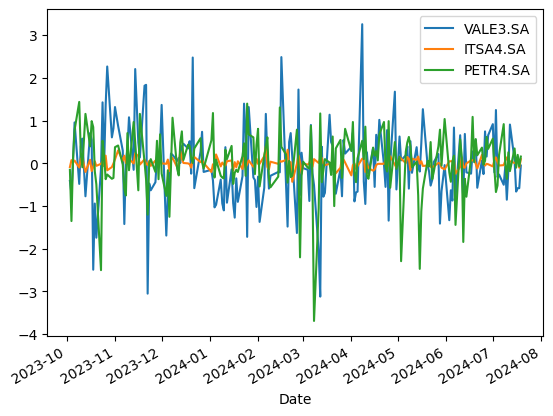

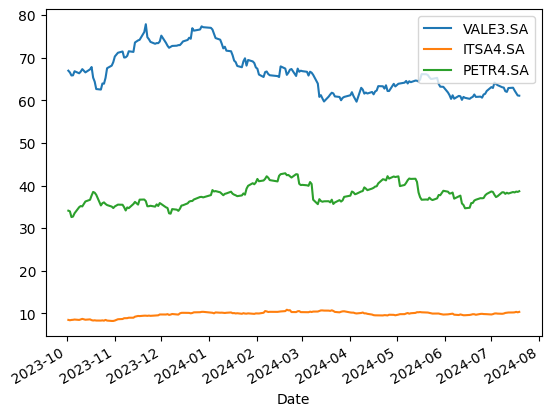

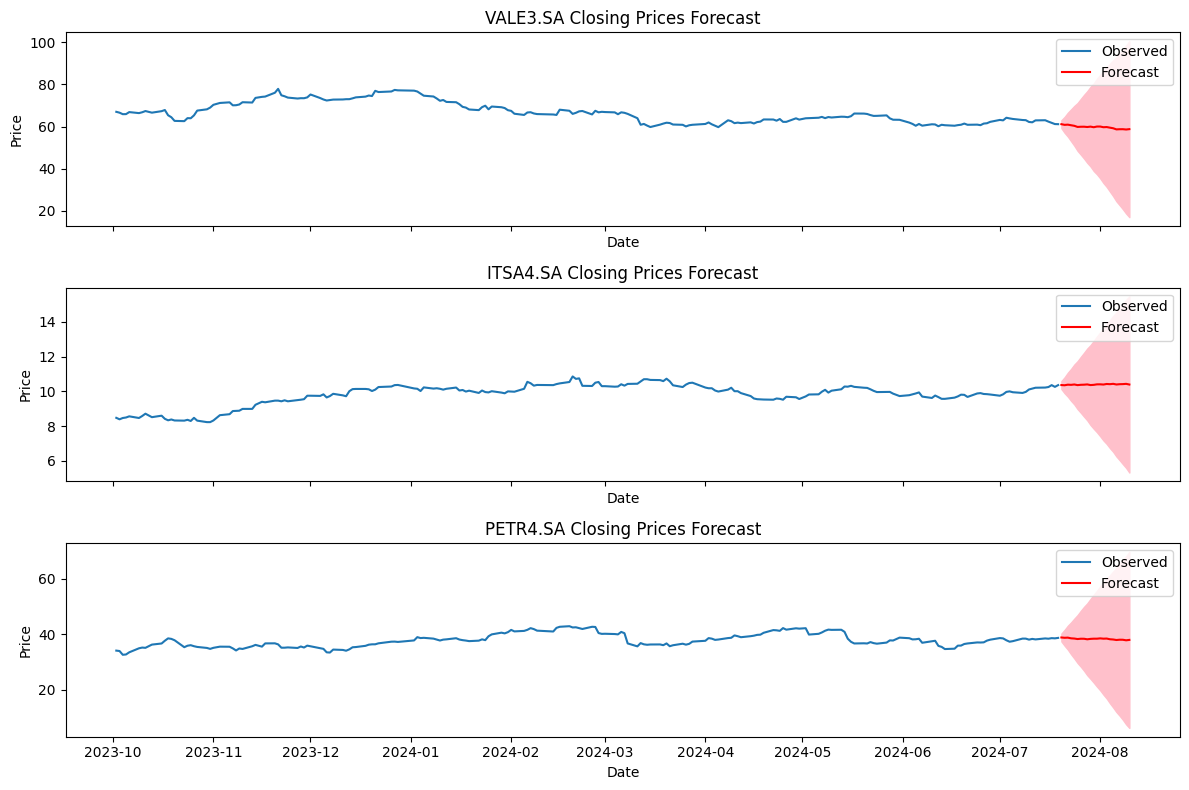

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm  # for progress bar
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Define the date range
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]
data = {ticker: yf.download(ticker, start="2023-10-01", end=to_date) for ticker in tickers}

# Extract the closing prices
close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})

# Calculate the difference in closing prices by date
close_prices_diff = close_prices.diff().dropna()
close_prices_diff.plot()
close_prices.plot()

# Function to fit and predict using SARIMAX
def fit_sarimax(ticker, close_prices_diff, close_prices, steps=22):
    model = sm.tsa.statespace.SARIMAX(close_prices_diff[ticker], 
                                      order=(1,1,1), 
                                      seasonal_order=(0,1,1,12), 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    pred_diff = results.get_forecast(steps=steps)
    pred_diff_ci = pred_diff.conf_int()
    
    # Convert differenced forecast to actual forecast
    last_actual = close_prices[ticker].iloc[-1]
    pred = last_actual + pred_diff.predicted_mean.cumsum()
    
    pred_ci = pred_diff_ci.cumsum() + last_actual
    
    # Generate date range for the forecast
    last_date = close_prices.index[-1]
    pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps)
    
    return pred, pred_ci, pred_dates

fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 8), sharex=True)

for i, ticker in enumerate(tickers):
    pred, pred_ci, pred_dates = fit_sarimax(ticker, close_prices_diff, close_prices)
    
    axes[i].plot(close_prices[ticker], label='Observed')
    axes[i].plot(pred_dates, pred, label='Forecast', color='red')
    axes[i].fill_between(pred_dates, 
                         pred_ci.iloc[:, 0], 
                         pred_ci.iloc[:, 1], color='pink')
    axes[i].set_title(f"{ticker} Closing Prices Forecast")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].legend()

plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\igor-\AppData\Local

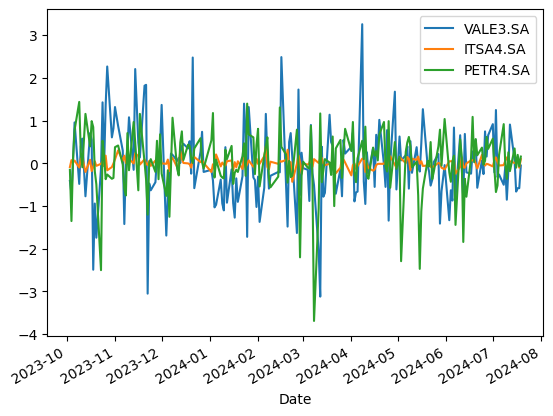

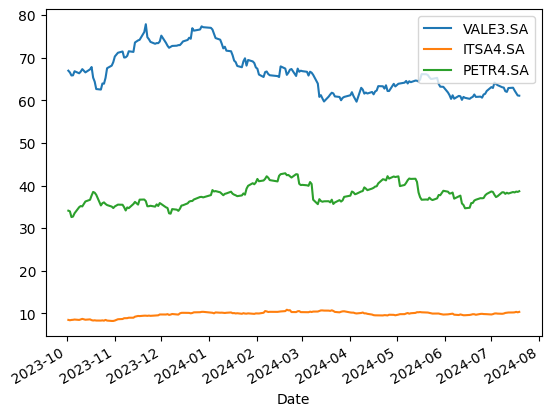

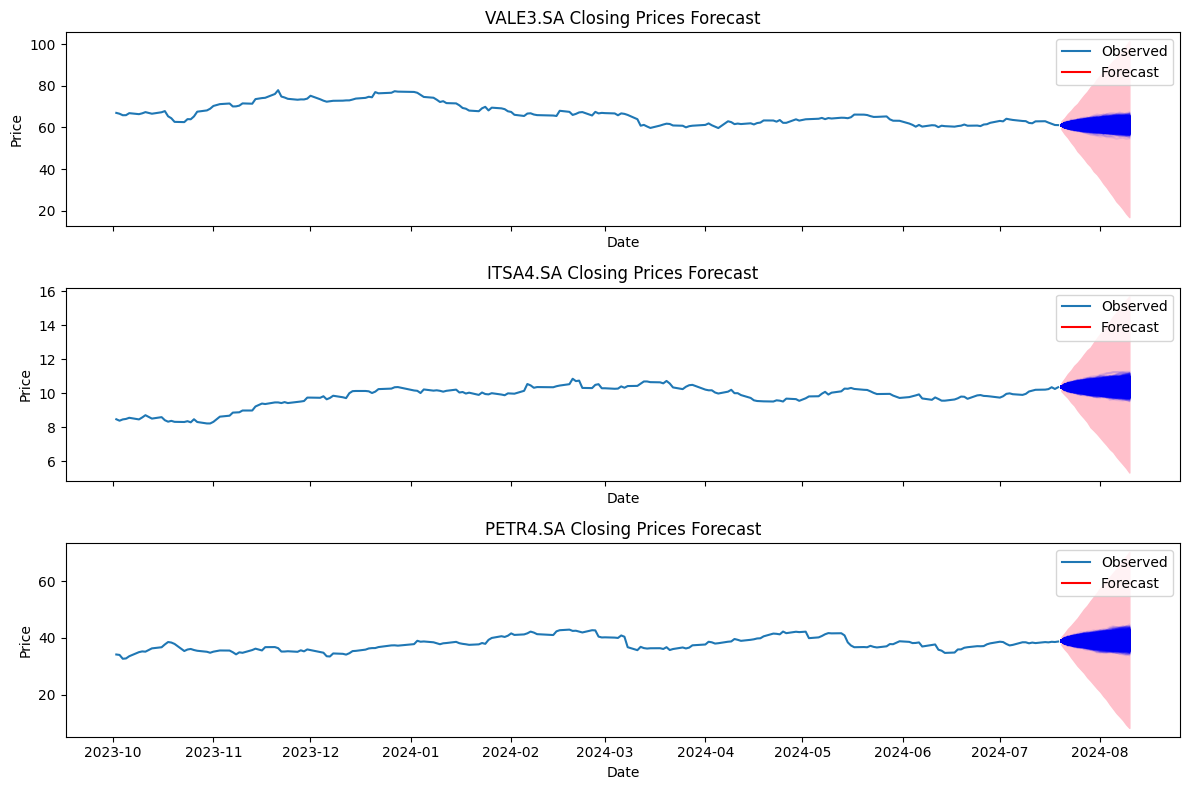

In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm  
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import os

to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]
data = {ticker: yf.download(ticker, start="2023-10-01", end=to_date) for ticker in tickers}


close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})


close_prices_diff = close_prices.diff().dropna()
close_prices_diff.plot()
close_prices.plot()

# SARIMAX
def fit_sarimax(ticker, close_prices_diff, close_prices, steps=22):
    model = sm.tsa.statespace.SARIMAX(close_prices_diff[ticker], 
                                      order=(1,1,1), 
                                      seasonal_order=(1,1,1,12), 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    pred_diff = results.get_forecast(steps=steps)
    pred_diff_ci = pred_diff.conf_int()
    
    # Converte a diff em forecast real
    last_actual = close_prices[ticker].iloc[-1]
    pred = last_actual + pred_diff.predicted_mean.cumsum()
    
    pred_ci = pred_diff_ci.cumsum() + last_actual
#Date Range pro forecast
    last_date = close_prices.index[-1]
    pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps)
    
    return pred, pred_ci, pred_dates


def simulate_gbm(start_price, mu, sigma, days, n_simulations=10000, volatility_factor=2):
    sigma *= volatility_factor  # Mexe na volatilidade
    dt = 1 / days
    prices = np.zeros((days, n_simulations))
    prices[0] = start_price
    for t in range(1, days):
        random_shocks = np.random.normal(mu * dt, sigma * np.sqrt(dt), n_simulations)
        prices[t] = prices[t-1] * np.exp(random_shocks)
    return prices

# criando função de tabela de probabilidade
def create_probability_table(gbm_simulations, pred_dates):
    rounded_simulations = np.round(gbm_simulations, 2)  # Round to two decimal places
    prob_table = pd.DataFrame(index=pred_dates)
    
    for day in range(rounded_simulations.shape[0]):
        value_counts = pd.Series(rounded_simulations[day]).value_counts(normalize=True)
        value_counts.name = pred_dates[day]
        prob_table = prob_table.join(value_counts, how='outer')
    
    prob_table = prob_table.fillna(0)
    prob_table.index.name = 'Value'
    return prob_table

fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 8), sharex=True)

# Create output directories if they don't exist
output_dir = "Saídas_modelos"
simulation_dir = os.path.join(output_dir, "Simulation")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(simulation_dir, exist_ok=True)

for i, ticker in enumerate(tickers):
    pred, pred_ci, pred_dates = fit_sarimax(ticker, close_prices_diff, close_prices)
    
    axes[i].plot(close_prices[ticker], label='Observed')
    axes[i].plot(pred_dates, pred, label='Forecast', color='red')
    axes[i].fill_between(pred_dates, 
                         pred_ci.iloc[:, 0], 
                         pred_ci.iloc[:, 1], color='pink')
    axes[i].set_title(f"{ticker} Closing Prices Forecast")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].legend()
    
    pred_df = pd.DataFrame({
        'Date': pred_dates,
        'Prediction': pred,
        'Lower_CI': pred_ci.iloc[:, 0],
        'Upper_CI': pred_ci.iloc[:, 1]
    }).set_index('Date')
    
    combined_df = pd.concat([close_prices[ticker], pred_df], axis=1)
    combined_df.columns = ['Actual', 'Prediction', 'Lower_CI', 'Upper_CI']
    
    combined_df.to_csv(os.path.join(output_dir, f"{ticker}_predictions.csv"))

    mu = 0  
    sigma = close_prices[ticker].pct_change().std()
    gbm_simulations = simulate_gbm(pred.iloc[0], mu, sigma, len(pred_dates), volatility_factor=2)
    
    sim_df = pd.DataFrame(gbm_simulations, index=pred_dates)
    sim_df.to_csv(os.path.join(simulation_dir, f"{ticker}_simulations.csv"))

    prob_table = create_probability_table(gbm_simulations, pred_dates)
    prob_table.to_csv(os.path.join(simulation_dir, f"{ticker}_probability_table.csv"))

    for sim in gbm_simulations.T:
        axes[i].plot(pred_dates, sim, color='blue', alpha=0.1)

plt.tight_layout()
plt.show()
